In [59]:
%env METAL_XCODE=1
%env DISABLE_COMPILER_CACHE=1

env: METAL_XCODE=1
env: DISABLE_COMPILER_CACHE=1


In [70]:
import numpy as np
from open3d import *
import matplotlib.pyplot as plt
from tinygrad import Tensor, dtypes
from scipy.spatial.transform import Rotation as R

In [71]:
point_cloud = io.read_point_cloud("../assets/Truck/sparse_pc.ply") # Read point cloud
point_cloud_array = np.asarray(point_cloud.points)
point_cloud_colors = np.asarray(point_cloud.colors)

# add one last 0 to the point_cloud array
point_cloud_array_homogeneous = np.hstack((point_cloud_array, np.ones((point_cloud_array.shape[0], 1))))
point_cloud_array_homogeneous_tinygrad = Tensor(point_cloud_array_homogeneous, requires_grad=True, dtype=dtypes.float32)

(3, 4)
(136614, 4)


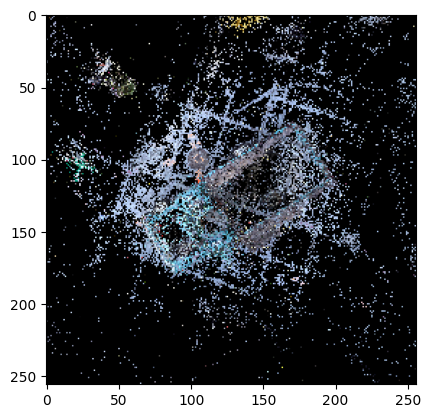

In [72]:
# We follow the convention K = [[fx, 0, cx], [0, fy, cy], [0, 0, 1]]
# Rt = [[R | t], [0, 0, 0, 1]]
# where the final projection matrix is P = K * Rt

K = Tensor(np.array([[256.0, 0.0, 0], [0.0, 256.0, 0], [0.0, 0.0, 1.0]]), requires_grad=False, dtype=dtypes.float32)
Rt = Tensor(np.array([[-1.0, 0.0, 0.0, -5], 
               [0.0, -1.0, 0.0, -5], 
               [0.0, 0.0, 1.0, -10]]), requires_grad=False, dtype=dtypes.float32)

P = K.dot(Rt)
print(P.shape)
print(point_cloud_array_homogeneous.shape)
point_2d = P.dot(point_cloud_array_homogeneous_tinygrad.transpose()).transpose()
point_2d = point_2d / point_2d[:, 2].reshape(-1, 1)
normalize_0_1 = (point_2d[:, :2]) / K[0,0]
normalize_0_1 = normalize_0_1.numpy()

mask = (normalize_0_1[:, 0] >= 0) & (normalize_0_1[:, 0] <= 1) & (normalize_0_1[:, 1] >= 0) & (normalize_0_1[:, 1] <= 1)
normalize_0_1 = normalize_0_1[mask]
colors = point_cloud_colors[mask]

# plot this points on a 256x256 image
image = np.zeros((256, 256, 3), dtype=np.uint8)

x = (normalize_0_1[:,0] * 256).astype(int)
y = (normalize_0_1[:,1] * 256).astype(int)

image[y, x] = colors[:, :3] * 255

plt.imshow(image)

In [139]:
K = Tensor(np.array([[256.0, 0.0, 0], [0.0, 256.0, 0], [0.0, 0.0, 1.0]]), requires_grad=False, dtype=dtypes.float32)
Rt = Tensor(np.array([[-1.0, 0.0, 0.0, -5], 
               [0.0, -1.0, 0.0, -5], 
               [0.0, 0.0, 1.0, -10]]), requires_grad=False, dtype=dtypes.float32)

P = K.dot(Rt)

# point2d camera space
point_2d = P.dot(point_cloud_array_homogeneous_tinygrad.transpose()).transpose()
point_2d = point_2d / point_2d[:, 2].reshape(-1, 1)

eyes = Tensor(np.array([np.eye(2)]).repeat(point_cloud_array_homogeneous.shape[0], axis=0), dtype=dtypes.float32)
eyes = eyes / (point_2d[:, 2].reshape(-1, 1, 1))


## coordinates
# scale of every gaussian
scale_s = 0.001
scale = np.array([scale_s, scale_s, scale_s])
# rotation of every gaussian
rotation = np.array([0,0,0])
r = R.from_euler('xyz', rotation, degrees=False)
s = np.diag(scale)

sigma_single = Tensor(np.array([r.as_matrix() @ s @ s @ r.as_matrix().T]), dtype=dtypes.float32)

# print(point_cloud_array_homogeneous.shape[0])
# print(sigma_single.numpy())
# print(sigma_single.shape)

sigma = sigma_single.repeat(point_cloud_array_homogeneous.shape[0],1,1)
sigma_n = Rt[:,:3] @ sigma @ Rt[:,:3].T

J = eyes.cat(point_2d[:, :2].reshape(-1, 2, 1), dim=2)

covariance_2d = J @ sigma_n @ J.transpose(2,1)
covariance_2d.numpy()




array([[[ 0.02823   ,  0.02394783],
        [ 0.02394783,  0.02031695]],

       [[ 0.03056782,  0.02321417],
        [ 0.02321416,  0.01763115]],

       [[ 0.02714439,  0.02067339],
        [ 0.02067339,  0.0157466 ]],

       ...,

       [[ 0.10047626, -0.16556925],
        [-0.16556923,  0.27283603]],

       [[ 0.00571699,  0.01168195],
        [ 0.01168195,  0.02387573]],

       [[ 0.02116364,  0.01369563],
        [ 0.01369563,  0.00886427]]], dtype=float32)

In [140]:
def generate_splat(coordinates, colors, covariance, img_size):
    kernel_size = img_size[0]
        
    W = img_size[0] # width of the image
    H = img_size[1] # height of the image
    batch_size = colors.shape[0] # number of Gaussians defined above

    inv_covariance, covariance_det = get_inverse_batched(covariance)

    x = np.linspace(-5, 5, kernel_size)
    y = np.linspace(-5, 5, kernel_size)
    yy, xx = Tensor(np.meshgrid(x, y))
    yy = yy.expand(batch_size, -1, -1)
    
    xx = xx.expand(batch_size, -1, -1)    

    xx = xx + coordinates[:,0].unsqueeze(1).unsqueeze(1) * 5
    yy = yy + coordinates[:,1].unsqueeze(1).unsqueeze(1) * 5

    xy = xx.stack(yy, dim=-1)
    z = Tensor.einsum('bxyi,bij,bxyj->bxy', xy, -0.5 * inv_covariance, xy)

    kernel = z.exp() / np.pi * covariance_det.sqrt().view(batch_size, 1, 1)
    kernel_max = kernel.max(axis=(1,2), keepdim=True) + 1e-6 # avoid division by zero
    kernel_norm = kernel / kernel_max 

    kernel_rgb = kernel_norm.unsqueeze(1).expand(-1, 3, -1, -1)
    rgb_values_reshaped = colors.unsqueeze(1).unsqueeze(1).permute(0,3,1,2)

    final_image_layers = rgb_values_reshaped * kernel_rgb    

    final_image = final_image_layers.sum(axis=0)

    final_image = final_image.clamp(0, 1)
    final_image = final_image.permute(1,2,0)

    return final_image

def get_inverse_batched(matrices):

    a = matrices[:,0,0]
    b = matrices[:,0,1]
    c = matrices[:,1,0]
    d = matrices[:,1,1]    

    det = a*d - b*c    

    d_new = d.unsqueeze(1)
    b_new = -b.unsqueeze(1)
    a_new = a.unsqueeze(1)
    c_new = -c.unsqueeze(1)

    top = d_new.cat(b_new, dim=1).unsqueeze(1)
    bottom = c_new.cat(a_new, dim=1).unsqueeze(1)

    inverse = top.stack(bottom, dim=2).reshape(-1,2,2) 
    inverse = inverse * (1.0 / det).unsqueeze(1).unsqueeze(1)

    return inverse, det

In [141]:
point_2d.numpy()

array([[ 168.01488 ,  142.53401 ,    1.      ],
       [ 174.83368 ,  132.77856 ,    1.      ],
       [ 164.7525  ,  125.481476,    1.      ],
       ...,
       [-316.97833 ,  522.3361  ,    1.      ],
       [  75.604195,  154.51451 ,    1.      ],
       [ 145.47383 ,   94.14495 ,    1.      ]], dtype=float32)

In [144]:
point_2d = point_2d / point_2d[:, 2].reshape(-1, 1)
normalize_n1_1 = ((point_2d[:, :2]) - (K[0,0]/2)) / (K[0,0]/2)
normalize_n1_1 = normalize_n1_1.numpy()
normalize_n1_1

mask = (normalize_n1_1[:, 0] >= -1) & (normalize_n1_1[:, 0] <= 1) & (normalize_n1_1[:, 1] >= -1) & (normalize_n1_1[:, 1] <= 1)
print(mask)
normalize_n1_1 = normalize_n1_1[mask]
covariance_2d = covariance_2d.numpy()[mask]
colors = point_cloud_colors[mask]
print(normalize_n1_1)

[ True  True  True ... False  True  True]
[[ 0.31261623  0.11354697]
 [ 0.36588812  0.03733253]
 [ 0.28712893 -0.01967597]
 ...
 [-0.28107876 -0.3117885 ]
 [-0.40934223  0.20714462]
 [ 0.1365143  -0.26449257]]


In [151]:
images_n = 3000
x_new = normalize_n1_1[:images_n,0]
y_new = normalize_n1_1[:images_n,1]
covariance_2d = covariance_2d[:images_n]
colors_new = colors[:images_n]

width = height = 256

In [149]:
coordinates = (Tensor(np.stack((x_new, y_new), axis=1), dtype=dtypes.float32))
coordinates.numpy()

covariances_simple = np.array([[[0.0001, 0], [0, 0.0001]]]).repeat(images_n, axis=0)

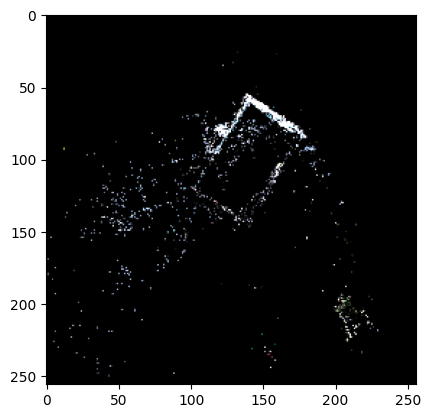

In [152]:
image = generate_splat(coordinates, Tensor(colors_new, dtype=dtypes.float32), Tensor(covariance_2d, dtype=dtypes.float32), (width, height))     

plt.imshow(image.numpy())

In [153]:
image = generate_splat(coordinates, Tensor(colors_new, dtype=dtypes.float32), Tensor(covariances_simple, dtype=dtypes.float32), (width, height))  
plt.imshow(image.numpy())   